In [48]:
%pip install -e ..
%load_ext autoreload
%autoreload 2

Obtaining file:///C:/Users/USER/Desktop/projects/Credit%20Score%20Modelling
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for credit-score-modelling (pyproject.toml): started
  Building editable for credit-score-modelling (pyproject.toml): finished with status 'done'
  Created wheel for credit-score-modelling: filename=credit_score_modelling-0.1.0-0.editable-py3-none-any.whl size=2389 sha256=73ef94a9581ddab6ccaf1fc9fea69a24063b21fdb90a10fbe8515b5baece6583
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-whee


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from credit_score.features.load_data import load_split
from credit_score.features.cleaning import fit_cleaning_metadata, clean_and_prepare

In [50]:
# Load raw split datasets
df_train = load_split("train")
df_val   = load_split("val")
df_test  = load_split("test")

# Fit cleaning metadata on train
metadata = fit_cleaning_metadata(df_train)

In [51]:
# Clean all datasets using train-based logic
df_train = clean_and_prepare(df_train, metadata)
df_val   = clean_and_prepare(df_val, metadata)
df_test  = clean_and_prepare(df_test, metadata)

Outliers removed: 11
Outliers removed: 3
Outliers removed: 1


In [52]:
df_train.shape, df_val.shape, df_test.shape

((34989, 33), (9997, 33), (4999, 33))

<h3 align='center' style="color:pink"> Feature Engineering </h3>

In [53]:
df_train["default"] = df_train["default"].astype(int)

In [54]:
df_train["loan_to_income"] = round(df_train["loan_amount"] / df_train["income"],2)
df_train["loan_to_income"].describe()

count    34989.000000
mean         1.557255
std          0.974709
min          0.300000
25%          0.770000
50%          1.160000
75%          2.460000
max          4.570000
Name: loan_to_income, dtype: float64

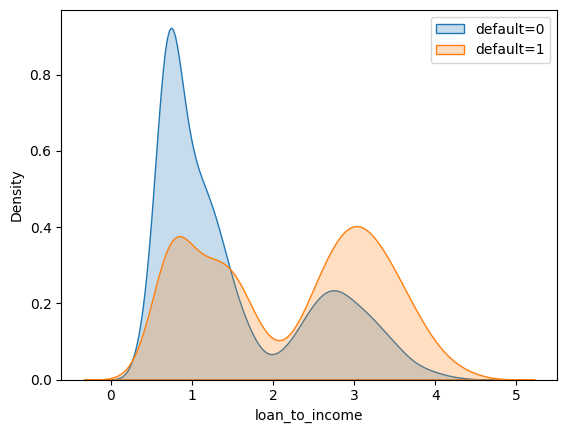

In [55]:
sns.kdeplot(df_train[df_train["default"] == 0]["loan_to_income"], fill=True, label='default=0')
sns.kdeplot(df_train[df_train["default"] == 1]["loan_to_income"], fill=True, label='default=1')
plt.legend()
plt.show()

In [56]:
df_train["deliquency_ratio"] = round(df_train["delinquent_months"]*100 / df_train["total_loan_months"],1)
df_train[["delinquent_months", "total_loan_months", "deliquency_ratio", ]].sample(5)

,delinquent_months,total_loan_months,deliquency_ratio
32690,0,95,0.0
30432,1,46,2.2
27004,9,47,19.1
30127,0,72,0.0
13969,23,93,24.7


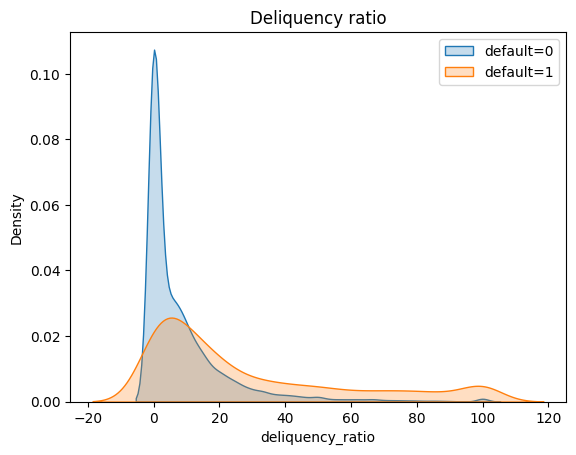

In [57]:
sns.kdeplot(df_train[df_train["default"] == 0]["deliquency_ratio"], fill=True, label='default=0')
sns.kdeplot(df_train[df_train["default"] == 1]["deliquency_ratio"], fill=True, label='default=1')
plt.title(f"Deliquency ratio")
plt.legend()
plt.show()

In [58]:
df_train["avg_dpd_per_deliquency"] = np.where(df_train["delinquent_months"] != 0,
                                              df_train["total_dpd"] / df_train["delinquent_months"], 0)
df_train["avg_dpd_per_deliquency"].describe()

count    34989.000000
mean         3.275402
std          2.908028
min          0.000000
25%          0.000000
50%          4.333333
75%          5.733333
max         10.000000
Name: avg_dpd_per_deliquency, dtype: float64

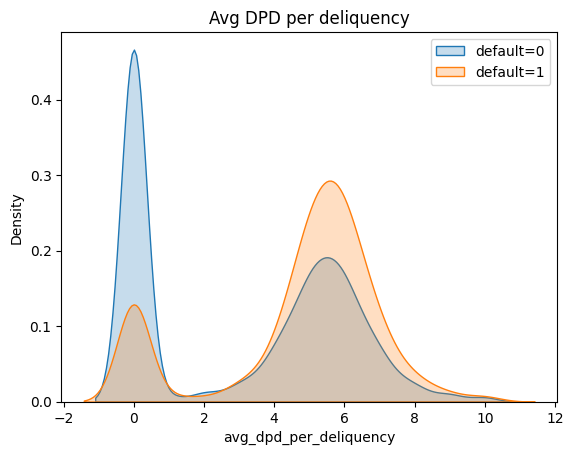

In [59]:
sns.kdeplot(df_train[df_train["default"] == 0]["avg_dpd_per_deliquency"], fill=True, label='default=0')
sns.kdeplot(df_train[df_train["default"] == 1]["avg_dpd_per_deliquency"], fill=True, label='default=1')
plt.title(f"Avg DPD per deliquency")
plt.legend()
plt.show()

<h3 align='center' style="color:pink"> Feature Selection </h3>

### Dropping rendundand columns - based on business needs and general understanding

In [60]:
df_train_cleaned = df_train.drop(["cust_id", "loan_id", "disbursal_date", "installment_start_dt", "loan_amount", "income", "total_loan_months", "delinquent_months", "total_dpd"], axis='columns').copy()

In [65]:
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34989 entries, 0 to 34999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          34989 non-null  int64  
 1   gender                       34989 non-null  object 
 2   marital_status               34989 non-null  object 
 3   employment_status            34989 non-null  object 
 4   number_of_dependants         34989 non-null  int64  
 5   residence_type               34989 non-null  object 
 6   years_at_current_address     34989 non-null  int64  
 7   city                         34989 non-null  object 
 8   state                        34989 non-null  object 
 9   zipcode                      34989 non-null  object 
 10  loan_purpose                 34989 non-null  object 
 11  loan_type                    34989 non-null  object 
 12  sanction_amount              34989 non-null  int64  
 13  processing_fee       

In [62]:
df_train_cleaned.select_dtypes(["int64", "float64"]).columns

Index(['age', 'number_of_dependants', 'years_at_current_address',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'deliquency_ratio',
       'avg_dpd_per_deliquency'],
      dtype='object')

### Scaling the columns and VIF

In [66]:
X_train = df_train_cleaned.drop('default',axis=1)
y_train = df_train_cleaned['default']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = df_train_cleaned.select_dtypes(["int64", "float64"]).columns

scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train.head(3)

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,...,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,deliquency_ratio,avg_dpd_per_deliquency
0,0.500000,M,Married,Self-Employed,0.6,Owned,0.866667,Bydgoszcz,kujawsko-pomorskie,85-001,...,0.509434,0.321305,0.108910,0.000000,0.5,0.25,0.070707,0.152225,0.000,0.00
1,0.384615,M,Married,Salaried,0.6,Owned,0.100000,Poznan,wielkopolskie,60-001,...,0.452830,0.135780,0.056609,0.666667,0.5,0.50,0.040404,0.683841,0.125,0.50
2,0.711538,F,Single,Self-Employed,0.2,Owned,0.466667,Bydgoszcz,kujawsko-pomorskie,85-001,...,0.000000,0.246263,0.129063,0.666667,0.0,0.50,0.262626,0.044496,0.130,0.58


In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Column"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [70]:
calculate_vif(X_train[cols_to_scale])

c:\Users\USER\Desktop\projects\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Column,VIF
0,age,5.560994
1,number_of_dependants,2.720735
2,years_at_current_address,3.367301
3,sanction_amount,101.788839
4,processing_fee,inf
5,gst,inf
6,net_disbursement,inf
7,loan_tenure_months,6.195942
8,principal_outstanding,16.272176
9,bank_balance_at_application,9.311481


In [72]:
features_to_drop_vif = ["sanction_amount", "processing_fee", "gst", "net_disbursement", "principal_outstanding"]

X_train_cleaned =  X_train.drop(features_to_drop_vif, axis=1)
num_col_cleaned = X_train_cleaned.select_dtypes(["int64", "float64"]).columns
num_col_cleaned

Index(['age', 'number_of_dependants', 'years_at_current_address',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'deliquency_ratio',
       'avg_dpd_per_deliquency'],
      dtype='object')

In [74]:
vif_df = calculate_vif(X_train_cleaned[num_col_cleaned])
vif_df

,Column,VIF
0,age,5.268435
1,number_of_dependants,2.716419
2,years_at_current_address,3.344760
3,loan_tenure_months,6.028186
4,bank_balance_at_application,1.798798
5,number_of_open_accounts,4.346676
6,number_of_closed_accounts,2.353432
7,enquiry_count,6.294548
8,credit_utilization_ratio,2.881049
9,loan_to_income,4.548434


In [75]:
selected_numeric_features_vif = vif_df.Column.values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'deliquency_ratio', 'avg_dpd_per_deliquency'], dtype=object)

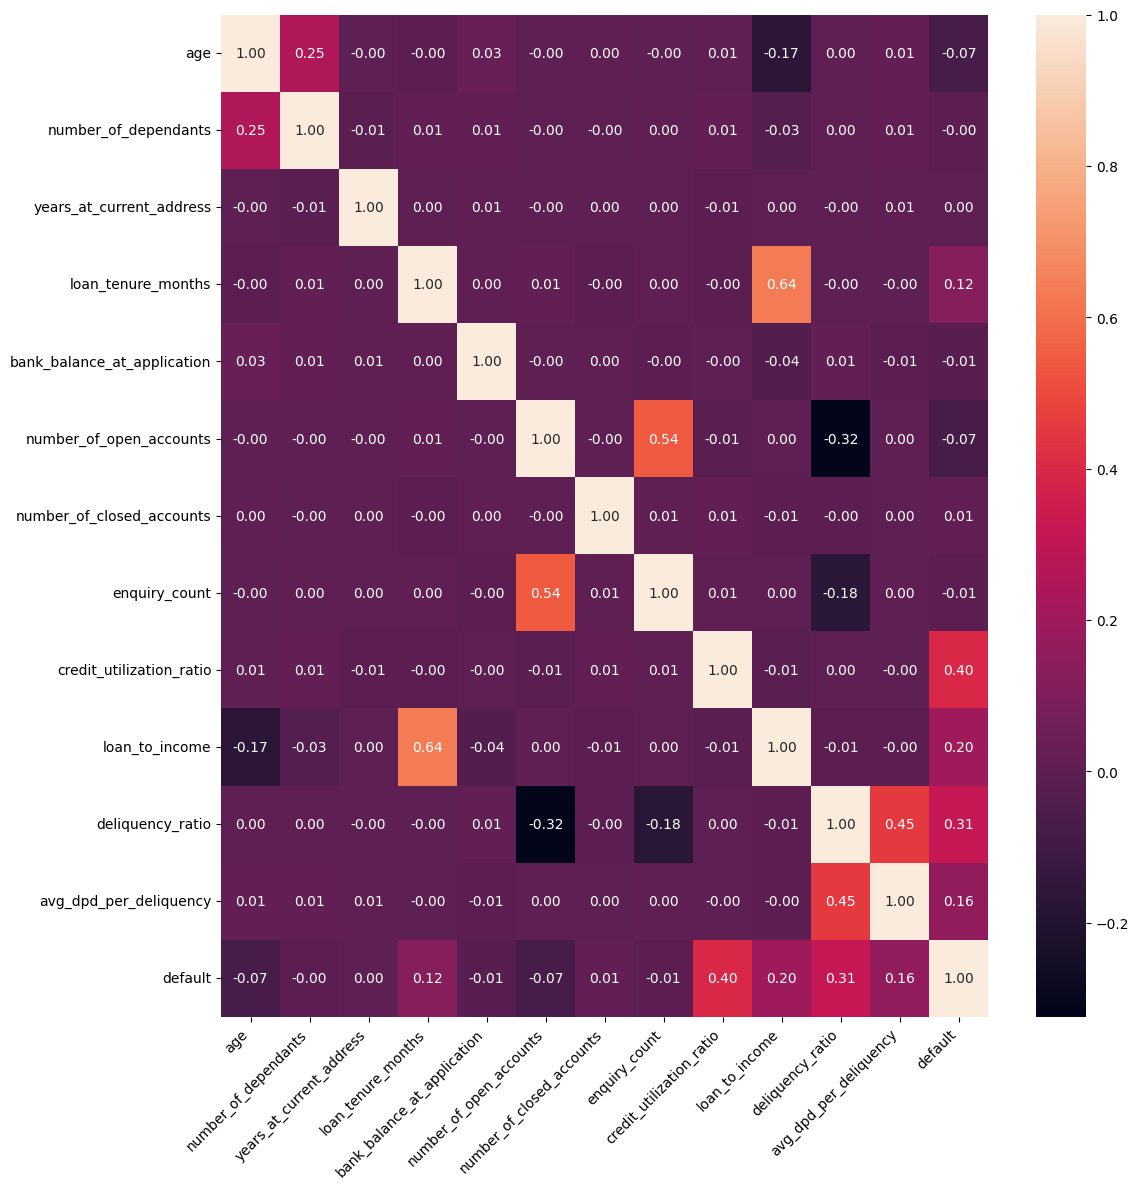

In [78]:
plt.figure(figsize=(12,12))
cm = df_train_cleaned[num_col_cleaned.append(pd.Index(["default"]))].corr()
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()